This notebook uses the already trained parameters to make predictions

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as r
from scipy.signal import correlate

In [31]:
# loading the MNIST dataset
file = np.loadtxt(r'C:\Users\ANUNAY CHANDRA\Desktop\ML-from-scratch\ML\CNN\archive\mnist_test.csv',delimiter=',',skiprows=1)
y = file[:,0]
X_flat = file[:,1:]

In [32]:
# function to convert flattened MNIST array to a matrix (gray-scale image)
def make_image(arr):
    arr = np.array(arr)
    img = []
    N = 28
    for i in range(N):
        img.append(arr[N*i:N*i+N])
    return np.array(img)

In [33]:
# using X_flat to get images (stored in X)
X = []
for x in X_flat:
    X.append(make_image(x))
X = np.array(X)

In [34]:
print(f'Shape of X_flat : {np.shape(X_flat)}')
print(f'Shape of X : {np.shape(X)}')

Shape of X_flat : (10000, 784)
Shape of X : (10000, 28, 28)


Building the CNN architecture :

1. Input Layer : (takes the MNIST 28x28 pixel image)
2. First Convolution (relu activation, two 5x5 kernels, 24x24 pixel image) -> Max Pooling (two 12x12 pixel images)
3. Second Convolution (relu activation, four two-channel 3x3 kernels, 10x10 pixel image) -> Maxpooling (four 5x5 pixel images)
4. Flattening : (100 cell 1D-array)
5. Normalizing the flattened array
6. Dense Neural Network : Input Layer (NN) -> Hidden Layer -> Output Layer

In [35]:
# ReLU function
def relu(x):
    return np.maximum(0,x)

In [36]:
def im2col(img, k):
    H, W = img.shape
    out_h = H - k + 1
    out_w = W - k + 1
    shape = (out_h, out_w, k, k)
    strides = img.strides + img.strides
    patches = np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)
    return patches

# convolution functions
def conv1(img, filters, biases):
    filters = np.array(filters)
    biases = np.array(biases)
    # filters: (N,5,5)
    # biases: (N,)
    # Extract all 5x5 patches -> (24,24,5,5)
    patches = im2col(img, 5)
    
    # Einstein multiply -> (N,24,24)
    R = np.einsum('nuv,ijuv->nij', filters, patches)
    R = R + biases[:, None, None]
    
    # ReLU
    C = relu(R)
    return R, C

def conv2(imgs, filters, biases):
    filters = np.array(filters)
    biases = np.array(biases)
    # imgs: (C,12,12)
    # filters: (F,C,3,3)
    # biases: (F,)
    
    C, H, W = imgs.shape
    F = filters.shape[0]
    
    # Extract patches for each channel -> (C,10,10,3,3)
    patches = np.stack([im2col(imgs[c], 3) for c in range(C)])
    
    # Multiply: sum over channels and kernel dims
    # filters: (F,C,3,3)
    # patches: (C,10,10,3,3)
    R = np.einsum('fcuv,cijuv->fij', filters, patches)
    
    # Add bias
    R = R + biases[:, None, None]
    
    # ReLU
    C_out = relu(R)
    return R, C_out

# maxpool function
def maxpool(img, pool_size=2):
    H, W = img.shape
    out_h = H // pool_size
    out_w = W // pool_size
    
    # reshape and max
    return img.reshape(out_h, pool_size, out_w, pool_size).max(axis=(1,3))

# kronecker delta
def kronecker_delta(i,j):
    if i==j:
        return 1
    else:
        return 0

# softmax function
def softmax(v):
    # takes vector v as input
    temp = np.exp(v-np.max(v))
    return temp/np.sum(temp)

# forward feeding for dense NN
def forward_feed_NN(a0,w,b):
    Z1 = np.matmul(w.T,a0)+b
    a1 = relu(Z1)
    return Z1, a1, softmax(a1)

# loss/cost function
def loss(y_true,y_pred):
    return -np.sum(y_true*np.log(y_pred))

(2, 24, 24)


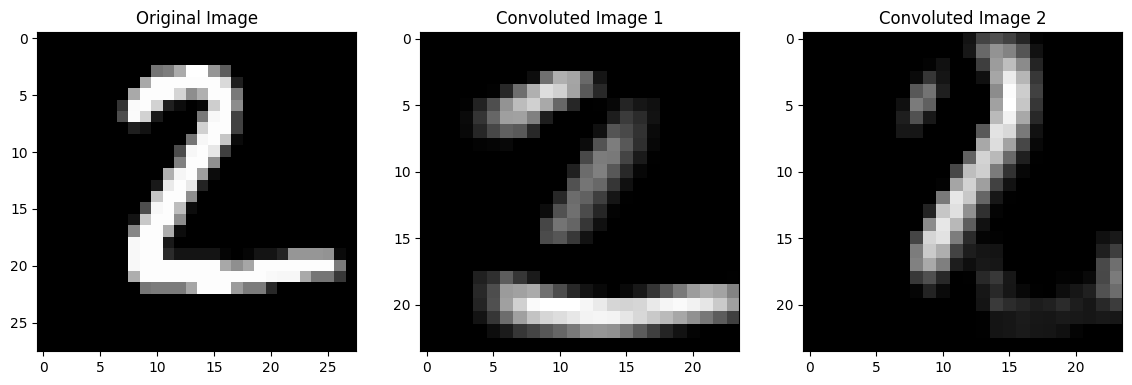

In [37]:
# testing the first conv function
filter1 = np.array([[2,2,4,2,2],[1,1,2,1,1],[0,0,0,0,0],[-1,-1,-2,-1,-1],[-2,-2,-4,-2,-2]])
filter2 = filter1.T
filters_5x5 = np.array([filter1,filter2])
img_index = 1
_,conv1_img = conv1(X[img_index],filters_5x5,[0,0])
print(np.shape(conv1_img))
plt.figure(figsize = (14,5))
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(X[img_index],cmap = 'gray')
plt.subplot(1,3,2)
plt.title('Convoluted Image 1')
plt.imshow(conv1_img[0],cmap = 'gray')
plt.subplot(1,3,3)
plt.title('Convoluted Image 2')
plt.imshow(conv1_img[1],cmap = 'gray')
plt.show()

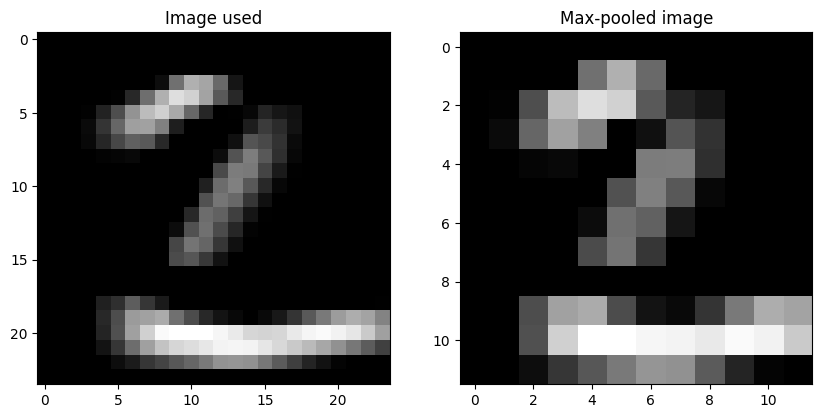

In [38]:
# testing the max-pool function
index = 0
pooled_img = maxpool(conv1_img[index])
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(conv1_img[index],cmap = 'gray')
plt.title('Image used')
plt.subplot(1,2,2)
plt.imshow(pooled_img,cmap = 'gray')
plt.title('Max-pooled image')
plt.show()

conv2 image shape: (4, 10, 10)


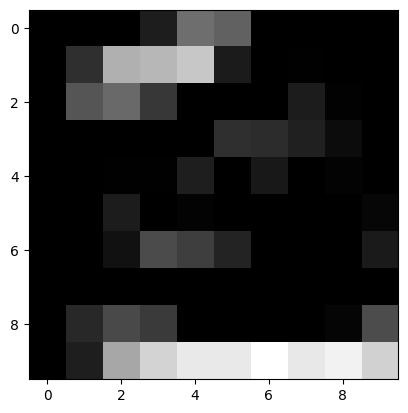

In [39]:
# testing the second convolution function
filter3 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
filter4 = np.array([[1,0,-1],[0,0,0],[-1,0,1]])
filter5 = np.array([[1,2,1],[0,0,0],[-1,0,-2]])
filter6 = filter5.T

filters_3x3 = np.array([
    [filter3, filter4],
    [filter5, filter6],
    [filter5, filter6],
    [filter5, filter6]
])

img1 = maxpool(conv1_img[0])
img2 = maxpool(conv1_img[1])
imgs = np.array([img1,img2])

# Pass ALL filters + 4 biases
_, conv2_img = conv2(imgs, filters_3x3, [0,0,0,0])
print("conv2 image shape:", conv2_img.shape)

plt.imshow(conv2_img[0], cmap='gray')
plt.show()


In [40]:
# forward feeding
def forward_feeding(img,filters_layer_1,filters_layer_2,bias_layer_1,bias_layer_2,w,b):
    # first layer feeding
    R_arr_1, conv_imgs_1 = conv1(img,filters_layer_1,bias_layer_1)
    
    # first maxpooling
    pooled_imgs_1 = []
    n1 = len(conv_imgs_1)                                            # this shall also be equal to the number of filters in the first convolution step
    for i in range(n1):
        pooled_imgs_1.append(maxpool(conv_imgs_1[i]))
    pooled_imgs_1 = np.array(pooled_imgs_1)
    
    # second layer feeding
    R_arr_2, conv_imgs_2 = conv2(pooled_imgs_1, filters_layer_2, bias_layer_2)

    # second maxpooling
    pooled_imgs_2 = []
    n2 = len(conv_imgs_2)
    for i in range(n2):
        pooled_imgs_2.append(maxpool(conv_imgs_2[i]))
    pooled_imgs_2 = np.array(pooled_imgs_2)
    
    # flattening and concattening the image matrices
    a0_unnorm = np.array([])
    s = len(pooled_imgs_2[0])
    for i in range(len(pooled_imgs_2)):
        vec_single = np.reshape(pooled_imgs_2[i],(s*s,))
        a0_unnorm = np.append(a0_unnorm,vec_single)

    # normalising the the vector
    max_val = np.max(a0_unnorm)
    if max_val == 0:
        print("WARNING: max(a0_unnorm) = 0")
        print("a0_unnorm:", a0_unnorm)
    a0_norm = a0_unnorm/max_val

    # feeding into dense neural network
    Z1, a1, y_pred_vec = forward_feed_NN(a0_norm,w,b)
    # shape of w : 100x10
    # shape of b : 10
    return R_arr_1, conv_imgs_1, pooled_imgs_1, R_arr_2, conv_imgs_2, pooled_imgs_2, a0_unnorm, a0_norm, Z1, a1, y_pred_vec

Loss Function : I used the cross-entropy loss function

$$ L = -\sum_{i=1}^{10} y_i\ln\hat{y}_i $$

In [41]:
# Backpropagation
def all_gradients(R_arr_1, conv_imgs_1, pooled_imgs_1,
                  R_arr_2, conv_imgs_2, pooled_imgs_2,
                  a0_unnorm, a0_norm, Z1, a1, y_pred_vec, y_true,
                  img, filters_layer_1, filters_layer_2,
                  bias_layer_1, bias_layer_2, w, b):

    # -----------------------------
    # 1. Dense layer (fully vectorized)
    # -----------------------------
    # softmax + cross-entropy gives dL/da1 = y_pred - y_true
    dL_da1 = y_pred_vec - y_true             # (10,)

    # ReLU on Z1
    relu_Z1_mask = (Z1 > 0).astype(float)    # (10,)
    dL_dZ1 = dL_da1 * relu_Z1_mask           # (10,)

    # Bias gradient (output layer)
    dLdb = dL_dZ1                            # (10,)

    # Weight gradient: W is (100,10), Z1 = W^T a0_norm
    dLdw = np.outer(a0_norm, dL_dZ1)         # (100,10)

    # Gradient wrt a0_norm
    dL_da0_norm = w @ dL_dZ1                 # (100,)

    # -----------------------------
    # 2. Backprop through normalization a0_norm = a0_unnorm / max(a0_unnorm)
    # -----------------------------
    M = np.max(a0_unnorm)
    idx_max = np.argmax(a0_unnorm)

    # Base term: ∂(a0_norm)/∂a0_unnorm ignoring max dependency
    dL_da0 = dL_da0_norm / M                 # (100,)

    # Correct for dependency of M = max(a0_unnorm)
    # dL/d a0_k -= (sum_j dL/da0_norm_j * a0_unnorm_j) / M^2   only for k = argmax
    S = np.dot(dL_da0_norm, a0_unnorm) / (M**2)
    dL_da0[idx_max] -= S

    # -----------------------------
    # 3. Backprop into pooled layer 2 (shape (4,5,5))
    # -----------------------------
    grad_pooled2 = dL_da0.reshape(pooled_imgs_2.shape)    # (4,5,5)

    # -----------------------------
    # 4. Backprop through maxpool2
    # -----------------------------
    F2, H2, W2 = conv_imgs_2.shape            # (4,10,10)
    pool = 2
    out_h2, out_w2 = H2 // pool, W2 // pool   # (5,5)

    # reshape conv2 outputs to match pooling blocks: (F, out_h, 2, out_w, 2)
    C2_reshaped = conv_imgs_2.reshape(F2, out_h2, pool, out_w2, pool)

    # max over each 2x2 block → pooled_imgs_2
    max_blocks2 = C2_reshaped.max(axis=(2, 4))    # (F,5,5)

    # mask for max locations
    mask2 = (C2_reshaped == max_blocks2[:, :, None, :, None])    # (F,5,1,5,1)

    # broadcast gradients back to the 2x2 blocks
    grad_pooled2_exp = grad_pooled2[:, :, None, :, None]         # (F,5,1,5,1)
    grad_C2_reshaped = mask2 * grad_pooled2_exp                  # (F,5,2,5,2)

    grad_C2 = grad_C2_reshaped.reshape(F2, H2, W2)               # (4,10,10)

    # -----------------------------
    # 5. Backprop through ReLU in conv2
    # -----------------------------
    dR2 = grad_C2 * (R_arr_2 > 0).astype(float)                  # (4,10,10)

    # -----------------------------
    # 6. Conv2 weight & bias gradients (using correlate, no pixel loops)
    # -----------------------------
    F2, C2_f, kh2, kw2 = filters_layer_2.shape                    # (4,2,3,3)

    # Bias gradients: sum over spatial positions
    dLdB_m2 = dR2.sum(axis=(1, 2))                               # (4,)

    # Kernel gradients: dL/dK2[f,c] = correlate(pooled1[c], dR2[f], mode='valid')
    dLdK_mn2_arr = np.zeros_like(filters_layer_2)                # (4,2,3,3)
    for f in range(F2):
        for c in range(C2_f):
            dLdK_mn2_arr[f, c] = correlate(pooled_imgs_1[c], dR2[f], mode='valid')

    # -----------------------------
    # 7. Gradient wrt pooled_imgs_1
    # -----------------------------
    # dL/dP1[c] = sum_f correlate(dR2[f], K2[f,c], mode='full')
    grad_pooled1 = np.zeros_like(pooled_imgs_1)                  # (2,12,12)
    for c in range(C2_f):
        acc = np.zeros_like(pooled_imgs_1[c])
        for f in range(F2):
            acc += correlate(dR2[f], filters_layer_2[f, c], mode='full')
        grad_pooled1[c] = acc

    # -----------------------------
    # 8. Backprop through maxpool1
    # -----------------------------
    C1, H1, W1 = conv_imgs_1.shape                               # (2,24,24)
    out_h1, out_w1 = H1 // pool, W1 // pool                      # (12,12)

    C1_reshaped = conv_imgs_1.reshape(C1, out_h1, pool, out_w1, pool)  # (2,12,2,12,2)
    max_blocks1 = C1_reshaped.max(axis=(2, 4))                        # (2,12,12)

    mask1 = (C1_reshaped == max_blocks1[:, :, None, :, None])         # (2,12,1,12,1)
    grad_pooled1_exp = grad_pooled1[:, :, None, :, None]              # (2,12,1,12,1)
    grad_C1_reshaped = mask1 * grad_pooled1_exp                       # (2,12,2,12,2)

    grad_C1 = grad_C1_reshaped.reshape(C1, H1, W1)                    # (2,24,24)

    # -----------------------------
    # 9. Backprop through ReLU in conv1
    # -----------------------------
    dR1 = grad_C1 * (R_arr_1 > 0).astype(float)                       # (2,24,24)

    # -----------------------------
    # 10. Conv1 weight & bias gradients (using correlate)
    # -----------------------------
    # Bias gradients
    dLdB_m1 = dR1.sum(axis=(1, 2))                                    # (2,)

    # Kernel gradients: dL/dK1[m] = correlate(img, dR1[m], mode='valid')
    dLdK_m1_arr = np.zeros_like(filters_layer_1)                      # (2,5,5)
    for m in range(C1):
        dLdK_m1_arr[m] = correlate(img, dR1[m], mode='valid')

    return dLdb, dLdw, dLdB_m2, dLdK_mn2_arr, dLdB_m1, dLdK_m1_arr


In [42]:
# building the CNN pipeline
def CNN(X_train,y_train,lr,n_epochs = 20):
    # number of training samples
    N = len(X_train)
    
    # randomly initialize the weights and biases
    b = r.rand(10)
    w = r.rand(100,10)
    B_layer_2 = r.rand(4)
    K_layer_2 = r.rand(4,2,3,3)
    B_layer_1 = r.rand(2)
    K_layer_1 = r.rand(2,5,5)

    # making a loss array
    loss_arr_epoch = []

    # loop for iterating over epochs
    for i in range(n_epochs):
        loss_arr = []
        for j in range(N):
            img = X_train[j]
            y_true_label = y_train[j]
            # forward feeding
            R_arr_1, conv_imgs_1, pooled_imgs_1, R_arr_2, conv_imgs_2, pooled_imgs_2, a0_unnorm, a0_norm, Z1, a1, y_pred_vec = forward_feeding(img,K_layer_1,K_layer_2,B_layer_1,B_layer_2,w,b)
            # evaluating the loss
            y_true_vec = np.array([kronecker_delta(s,y_true_label) for s in range(10)])
            loss_arr.append(loss(y_true_vec,y_pred_vec))
            # back-propagation
            dLdb,dLdw,dLdB_m2,dLdK_mn2_arr,dLdB_m1,dLdK_m1_arr = all_gradients(R_arr_1, conv_imgs_1, pooled_imgs_1, R_arr_2, conv_imgs_2, pooled_imgs_2, a0_unnorm, a0_norm, Z1, a1, y_pred_vec, y_true_vec, img, K_layer_1, K_layer_2, B_layer_1, B_layer_2, w, b)
            # updating weights and biases
            b = b - lr*dLdb
            w = w - lr*dLdw
            B_layer_2 = B_layer_2 - lr*dLdB_m2
            K_layer_2 = K_layer_2 - lr*dLdK_mn2_arr
            B_layer_1 = B_layer_1 - lr*dLdB_m1
            K_layer_1 = K_layer_1 - lr*dLdK_m1_arr
        loss_arr_epoch.append(np.mean(np.array(loss_arr)))
        if (i+1)%int(n_epochs/10) == 0:
            print(f'{100*(i+1)/n_epochs} % training completed')
    return B_layer_1,K_layer_1,B_layer_2,K_layer_2,b,w,loss_arr_epoch

In [43]:
# Splitting the data into training and testing set
boundary = 5000
X_train = X[:boundary]
y_train = y[:boundary]
X_test = X[boundary:boundary+5000]
y_test = y[boundary:boundary+5000]

In [44]:
# running the model
n_epochs = 2000
learning_rate = 0.01
# B_layer_1,K_layer_1,B_layer_2,K_layer_2,b,w,loss_arr_epoch = CNN(X_train,y_train,lr=learning_rate,n_epochs=n_epochs)
print(f'Total learnable parameters : {2*(5*5+1)+4*(2*3*3+1)+100*10+10}')

Total learnable parameters : 1138


In [45]:
# # saving learnt parameters
# np.savez("cnn_parameters1.npz",
#          K_layer_1=K_layer_1,
#          B_layer_1=B_layer_1,
#          K_layer_2=K_layer_2,
#          B_layer_2=B_layer_2,
#          w=w,
#          b=b,
#          loss_arr_epoch=loss_arr_epoch,
#          n_epochs=n_epochs,
#          learning_rate=learning_rate)
# print("Saved trained parameters to cnn_parameters1.npz")

In [46]:
# to load learnt parameters
params = np.load("cnn_parameters1.npz")
K_layer_1 = params["K_layer_1"]
B_layer_1 = params["B_layer_1"]
K_layer_2 = params["K_layer_2"]
B_layer_2 = params["B_layer_2"]
w = params["w"]
b = params["b"]
loss_arr_epoch = params["loss_arr_epoch"]
print("Loaded trained parameters from cnn_parameters1.npz")

Loaded trained parameters from cnn_parameters1.npz


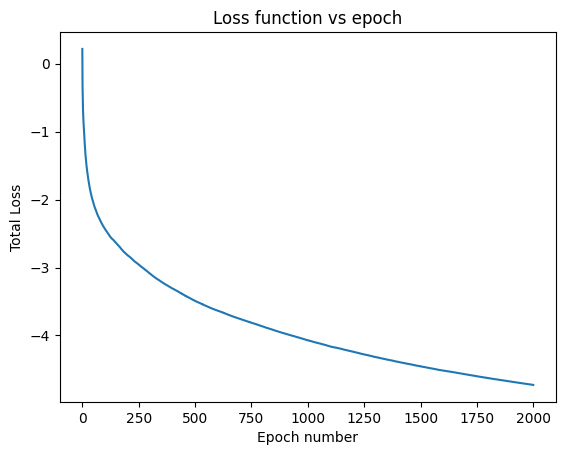

In [47]:
plt.plot(np.arange(n_epochs),np.log(loss_arr_epoch))
plt.title('Loss function vs epoch')
plt.xlabel('Epoch number')
plt.ylabel('Total Loss')
plt.show()

In [48]:
# making predictions from the learnt parameters
def predict(B_layer_1,K_layer_1,B_layer_2,K_layer_2,b,w,X_test):
    y_pred = []
    for i in range(len(X_test)):
        _,_,_,_,_,_,_,_,_,_,prob_vector = forward_feeding(X_test[i],K_layer_1,K_layer_2,B_layer_1,B_layer_2,w,b)
        y_pred.append(np.argmax(prob_vector))
    return np.array(y_pred)

In [49]:
# testing network accuracy
y_test_pred = predict(B_layer_1,K_layer_1,B_layer_2,K_layer_2,b,w,X_test)
n_correct_predictions = 0
for i in range(len(y_test_pred)):
    if y_test[i]==y_test_pred[i]:
        n_correct_predictions+=1
print('Total number of test samples :',len(X_test))
print('Total number of correct predictions :',n_correct_predictions)
print('Accuracy Score :',n_correct_predictions/len(y_test_pred))
# print(f'----------------------------------------------------------\nTest targets:\n{y_test}')
# print(f'----------------------------------------------------------\nTest Predictions:\n{y_test_pred}')
print(f'----------------------------------------------------------\nComparision [Correct, Predicted]:\n{np.array(list(zip(y_test,y_test_pred)))}')

Total number of test samples : 5000
Total number of correct predictions : 4780
Accuracy Score : 0.956
----------------------------------------------------------
Comparision [Correct, Predicted]:
[[3. 3.]
 [9. 9.]
 [9. 9.]
 ...
 [4. 4.]
 [5. 5.]
 [6. 6.]]


# What does the network see?

In [50]:
test_img_index = 0
R_arr_1, conv_imgs_1, pooled_imgs_1, R_arr_2, conv_imgs_2, pooled_imgs_2, a0_unnorm, a0_norm, Z1, a1, y_pred_vec = forward_feeding(X_test[test_img_index],K_layer_1,K_layer_2,B_layer_1,B_layer_2,w,b)

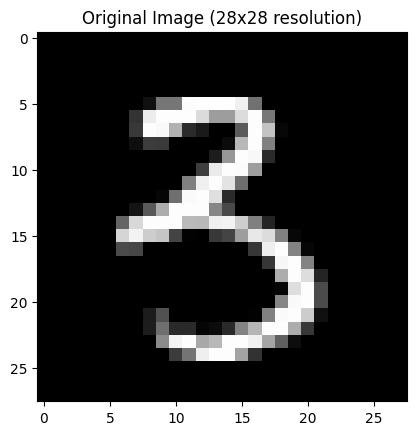

In [51]:
# original image
plt.imshow(X_test[test_img_index],cmap = 'gray')
plt.title('Original Image (28x28 resolution)')
plt.show()

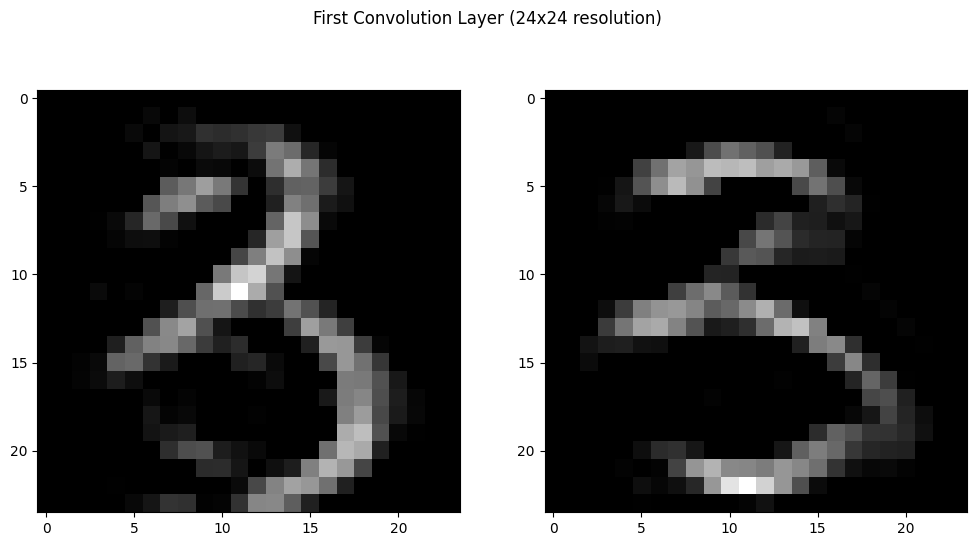

In [52]:
# first convolution layer (2 images)
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.imshow(conv_imgs_1[0],cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(conv_imgs_1[1],cmap = 'gray')
plt.suptitle('First Convolution Layer (24x24 resolution)')
plt.show()

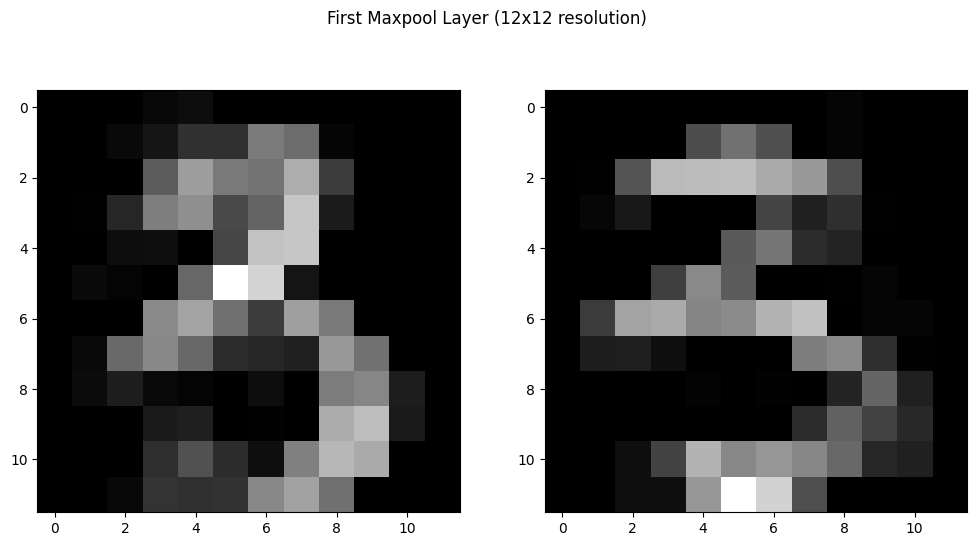

In [53]:
# first maxpool layer (2 images)
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.imshow(pooled_imgs_1[0],cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(pooled_imgs_1[1],cmap = 'gray')
plt.suptitle('First Maxpool Layer (12x12 resolution)')
plt.show()

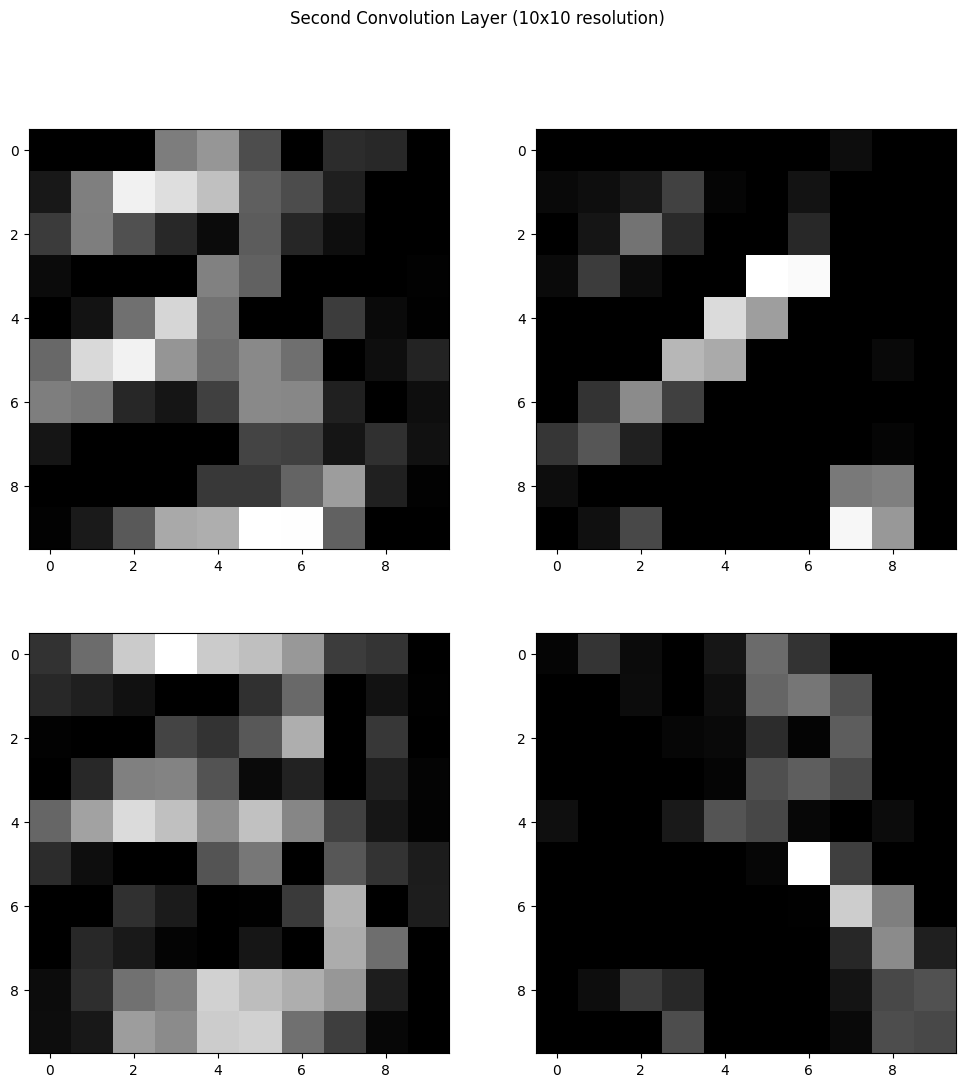

In [54]:
# second convolution layer (4 images)
plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
plt.imshow(conv_imgs_2[0],cmap = 'gray')
plt.subplot(2,2,2)
plt.imshow(conv_imgs_2[1],cmap = 'gray')
plt.subplot(2,2,3)
plt.imshow(conv_imgs_2[2],cmap = 'gray')
plt.subplot(2,2,4)
plt.imshow(conv_imgs_2[3],cmap = 'gray')
plt.suptitle('Second Convolution Layer (10x10 resolution)')
plt.show()

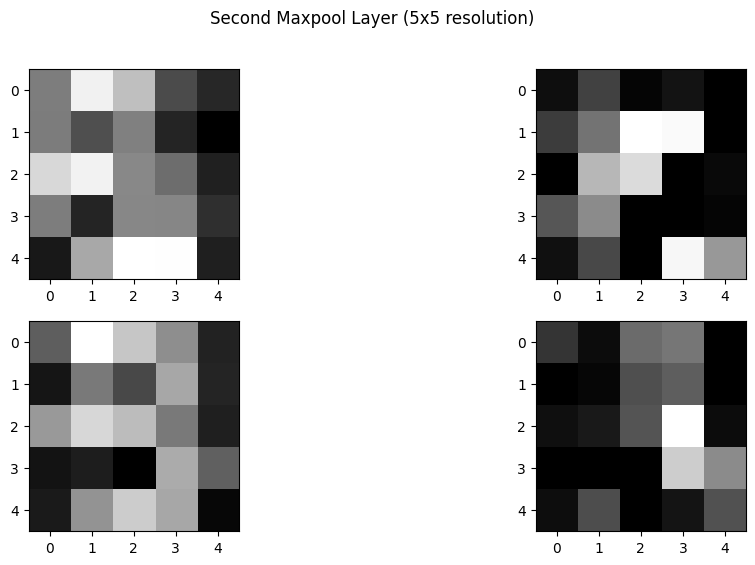

In [55]:
# second maxpool layer (4 images)
plt.figure(figsize = (12,6))
plt.subplot(2,2,1)
plt.imshow(pooled_imgs_2[0],cmap = 'gray')
plt.subplot(2,2,2)
plt.imshow(pooled_imgs_2[1],cmap = 'gray')
plt.subplot(2,2,3)
plt.imshow(pooled_imgs_2[2],cmap = 'gray')
plt.subplot(2,2,4)
plt.imshow(pooled_imgs_2[3],cmap = 'gray')
plt.suptitle('Second Maxpool Layer (5x5 resolution)')
plt.show()

In [56]:
# final probabilities
print("Probabilities:")
print("[" + "  ".join(f"{p:.3f}" for p in y_pred_vec) + "]")

Probabilities:
[0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]


# Learned Parameters

In [57]:
# Filters and Biases
print(f'...................................................\nFirst Layer Kernels\n...................................................\n')
print(K_layer_1)
print('...................................................\n\n')

print(f'...................................................\nFirst Layer Biases\n...................................................\n')
print(B_layer_1)
print('...................................................\n\n')

print(f'...................................................\nSecond Layer Kernels\n...................................................\n')
print(K_layer_2)
print('...................................................\n\n')

print(f'...................................................\nSecond Layer Biases\n...................................................\n')
print(B_layer_2)
print('...................................................\n\n')


...................................................
First Layer Kernels
...................................................

[[[-1.86728833 -1.17118749  4.24214908  1.48652116  0.89542974]
  [ 2.06645142  0.62795352  3.32291361 -3.54574807 -1.92151746]
  [ 0.34413108  2.6775976  -0.42950862  0.83079417 -3.88971757]
  [ 0.09683549  0.20532152  2.70599396  0.9161706  -0.51899986]
  [-0.76689608  1.00775979 -2.17868185  2.54306903 -1.18011785]]

 [[-1.10719564 -3.13981645 -3.75303063 -2.51104133  0.22729826]
  [ 6.21468713  2.49757803  1.72543758 -0.1012804   2.69836355]
  [-1.16837805  4.14915575  4.33716299  4.82807154 -2.13117857]
  [-3.17725038  0.65187314  0.07341073  1.5857616   1.39014443]
  [ 0.97815154 -2.20241572 -4.23453631 -2.76056777 -3.56807193]]]
...................................................


...................................................
First Layer Biases
...................................................

[-0.38135839 -0.16828094]
...........................